## Investigating  Data
Use the apple mobility data set attached as a zipped csv. Read in the raw data, and filter to any two countries. Resample to weekly data and find if they are correlated

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# read df
df = pd.read_csv("data\\apple_mobility_data.zip", low_memory=False)

# important columns for country data
dim_cols = ['region', 'transportation_type']
date_cols = list(df.columns[6:].values)
transportation_types = df['transportation_type'].unique()

# restrict to countries
country_df = df[df['geo_type'] == 'country/region']
country_df = country_df[dim_cols + date_cols].copy()
country_df.head()

,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,...,2022-02-15,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24
0,Albania,driving,100.0,95.30,101.43,97.20,103.55,112.67,104.83,94.39,...,156.04,159.59,158.80,173.06,196.42,179.48,163.30,155.11,155.52,165.68
1,Albania,walking,100.0,100.68,98.93,98.46,100.85,100.13,82.13,95.65,...,185.16,171.73,198.46,216.12,210.41,159.66,201.41,188.36,205.25,208.44
2,Argentina,driving,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,...,114.10,116.78,119.40,142.49,148.51,99.60,108.15,110.96,116.21,119.52
3,Argentina,walking,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,...,119.62,126.77,133.51,151.40,132.82,83.20,121.40,128.47,133.02,123.65
4,Australia,driving,100.0,102.98,104.21,108.63,109.08,89.00,99.35,103.53,...,131.07,134.70,146.48,145.41,121.64,129.18,130.65,132.81,133.67,145.25


In [4]:
def prep_by_country(df, countries):
    """Filter to given countries and
    prepare date columns to rows."""
    df = df[df['region'].isin(countries)]
    df = df.melt(id_vars=['region', 'transportation_type'], var_name='Date', value_name='mobility')
    df['Date'] = df['Date'].apply(pd.to_datetime)
    
    return df

def resample(df, cols, sampling='W'):
    """Resample by given cols"""
    df = df.set_index('Date')
    return df.groupby(cols).resample(sampling).mean(numeric_only=True).reset_index()

# US country overall
us_df = prep_by_country(country_df, ['United States'])
# We call it weekly but let's do daily
weekly_us_df = resample(us_df, ['region'], sampling='D')
weekly_us_trans_df = resample(us_df, ['region', 'transportation_type'], sampling='D')
weekly_us_trans_df.head()

,region,transportation_type,Date,mobility
0,United States,driving,2020-01-13,100.00
1,United States,driving,2020-01-14,102.97
2,United States,driving,2020-01-15,105.19
3,United States,driving,2020-01-16,108.48
4,United States,driving,2020-01-17,125.51


In [5]:
# transpose transportation_type to features
weekly_us_trans_processed = weekly_us_trans_df.pivot_table(index=['region', 'Date'], columns='transportation_type', values='mobility').reset_index()

# one-hot encoding for transportation type
# weekly_us_trans_processed = pd.get_dummies(weekly_us_trans_processed, columns=['transportation_type'])

# Add overall mobility
weekly_us_processed = pd.merge(weekly_us_trans_processed, weekly_us_df, on=['region', 'Date'], how='left')
weekly_us_processed.columns = ['region', 'Date', 'driving', 'transit', 'walking', 'overall']

temporal_features = ['weekday', 'month', 'year']

def add_weekday_month(df, dt_col='Date'):
    """Add weekday and month"""
    df['weekday'] = df[dt_col].dt.weekday
    df['month'] = df[dt_col].dt.month
    df['year'] = df[dt_col].dt.year - min(df[dt_col].dt.year)
    return df

weekly_us_processed = add_weekday_month(weekly_us_processed)

def normalize(df, cols):
    """normalize numeric columns"""
    df[cols] = MinMaxScaler().fit_transform(df[cols])
    return df

weekly_us_processed = normalize(weekly_us_processed, ['driving', 'walking', 'transit', 'overall'] + temporal_features)
weekly_us_processed.head()

,region,Date,driving,transit,walking,overall,weekday,month,year
0,United States,2020-01-13,0.395675,0.675570,0.292068,0.432730,0.000000,0.0,0.0
1,United States,2020-01-14,0.414454,0.656957,0.290248,0.433412,0.166667,0.0,0.0
2,United States,2020-01-15,0.428490,0.665888,0.300368,0.444927,0.333333,0.0,0.0
3,United States,2020-01-16,0.449292,0.667557,0.294731,0.449516,0.500000,0.0,0.0
4,United States,2020-01-17,0.556968,0.742592,0.386879,0.546225,0.666667,0.0,0.0


## Build model and test accuracy

### Baseline - Linear Regression
No lag. Remove highly dependent feature columns.

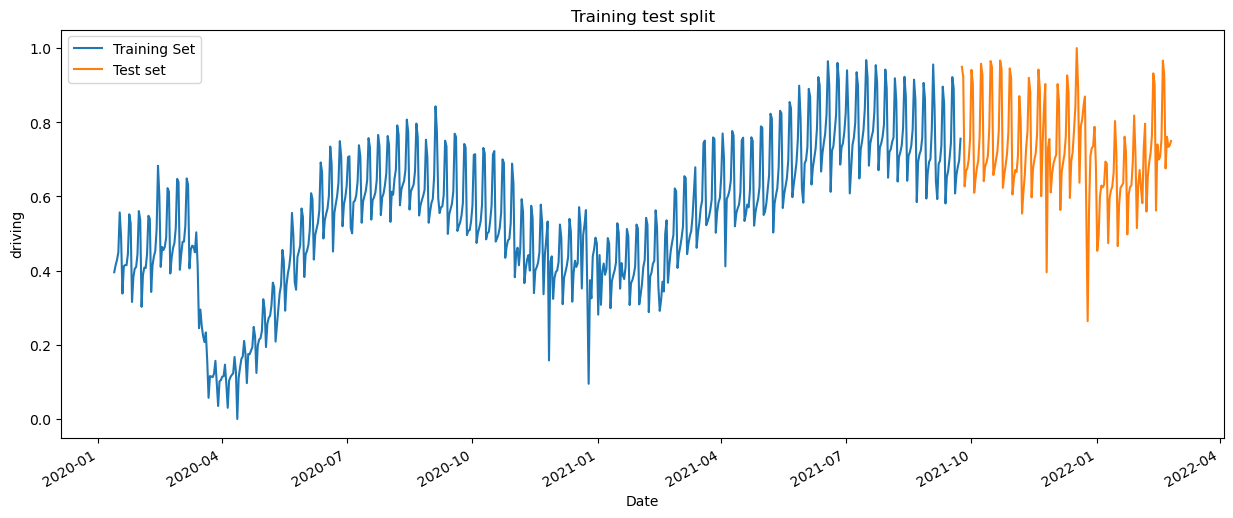

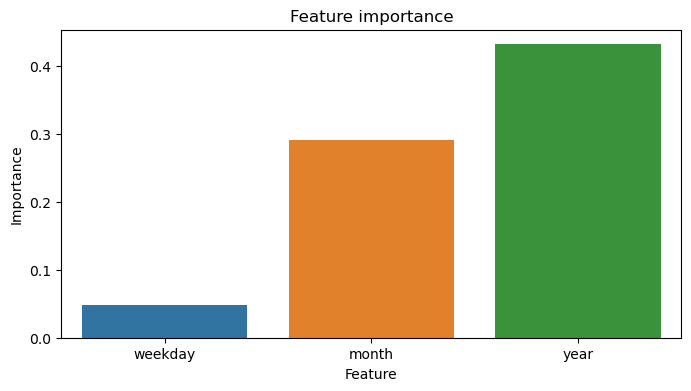

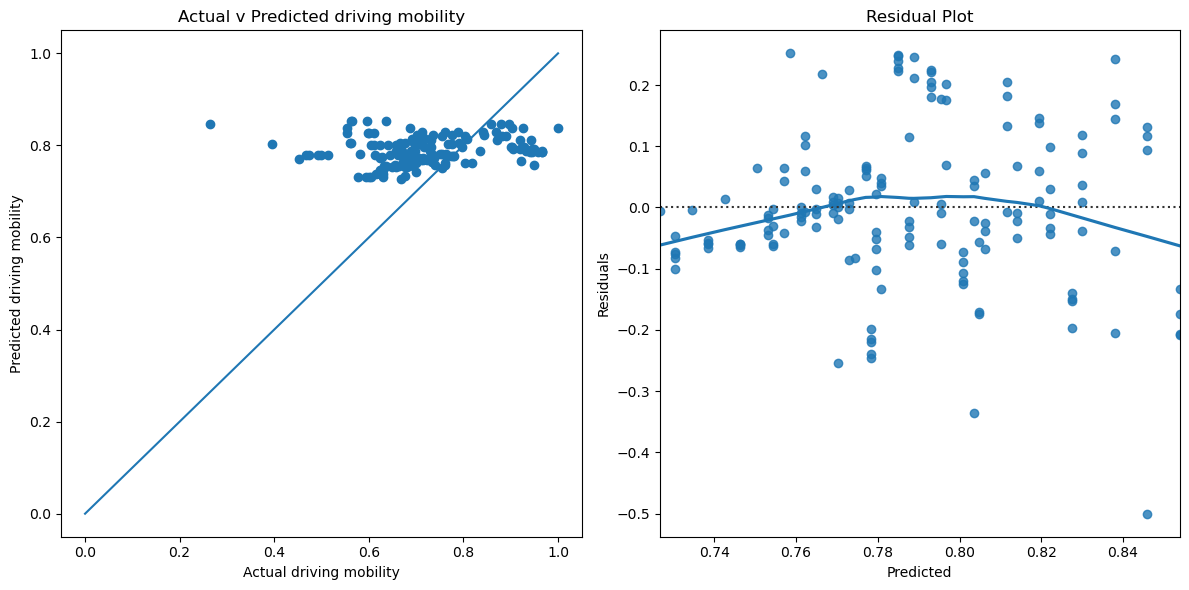

Baseline Linear Regression: MSE: 0.0206, RMSE: 0.1435, R-squared: -0.2495


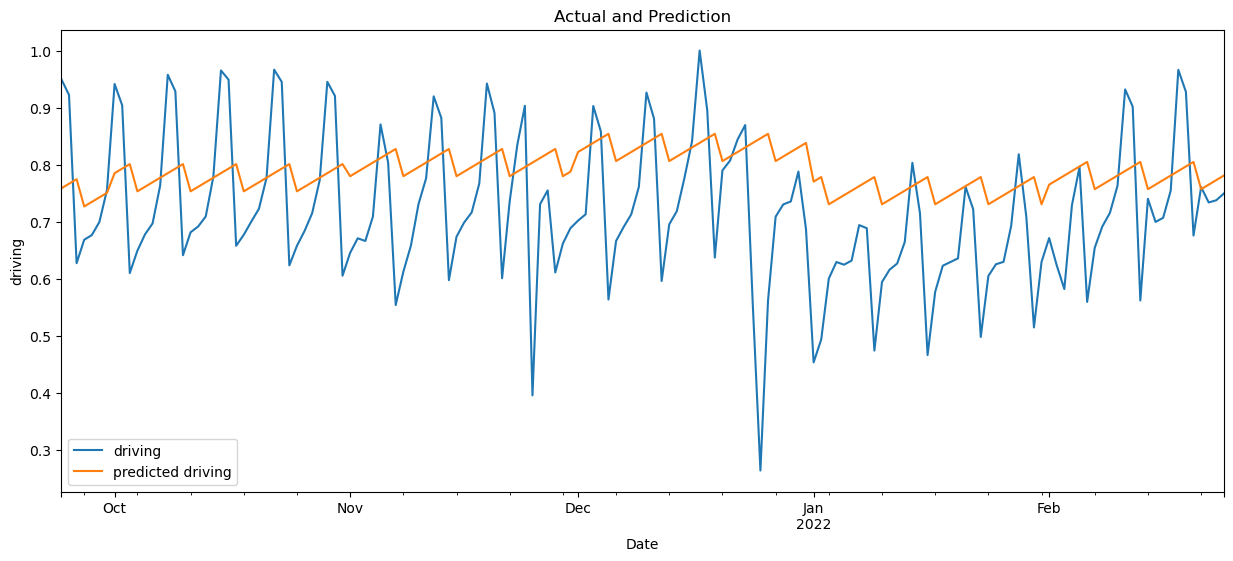

In [6]:
def split_data(df, features, prediction, split=.8, plot=True):
    date_to_split_on = df.iloc[int(split * len(df.index))]["Date"]
    train = df[df["Date"] <= date_to_split_on]
    test = df[df["Date"] > date_to_split_on]
    if plot:
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.set_title("Training test split")
        train.plot("Date", y=prediction, ax=ax, label='Training Set', ylabel=prediction)
        test.plot("Date", y=prediction, ax=ax, label='Test set', ylabel=prediction)
    return train[features], test[features], train[["Date", prediction]], test[["Date", prediction]]

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def plot_model(y_test, y_pred, prediction):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.scatter(y_test[prediction], y_pred)
    ax1.plot([0, 1], [0, 1])
    ax1.set_xlabel(f'Actual {prediction} mobility')
    ax1.set_ylabel(f'Predicted {prediction} mobility')
    ax1.set_title(f'Actual v Predicted {prediction} mobility')

    # Residual plot
    sns.residplot(x=y_pred, y=y_test[prediction] - y_pred, lowess=True, ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')

    plt.tight_layout()
    plt.show()

def plot_series(y_test, y_pred, prediction):
    """Plot the test actual and predicted series"""
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set_title("Actual and Prediction")
    y_test.plot("Date", y=prediction, ax=ax, ylabel=prediction)
    ax.plot(y_test['Date'], y_pred, label=f'predicted {prediction}')
    ax.legend()

def plot_feature_importance(features, importance):
    plt.figure(figsize=(8,4))
    sns.barplot(data=pd.DataFrame(zip(features, importance)), x=0, y=1)
    plt.title('Feature importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')    
    plt.show()

def evaluate_model(model, y_test, y_pred, prediction):
    mse = mean_squared_error(y_test[prediction], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[prediction], y_pred)
    return mse, rmse, r2, y_pred

def pipeline(model, df, features, prediction, plot=True):
    X_train, X_test, y_train, y_test = split_data(df, features, prediction, split=.8, plot=plot)
    model = train_model(model, X_train, y_train[prediction])
    y_pred = model.predict(X_test)
    if plot:
        plot_feature_importance(features, model.coef_)
        plot_model(y_test, y_pred, prediction)
        plot_series(y_test, y_pred, prediction)
        
    return model, evaluate_model(model, y_test, y_pred, prediction)

_model, (mse, rmse, r2, _) = pipeline(LinearRegression(), weekly_us_processed, temporal_features, 'driving')
print(f'Baseline Linear Regression: MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

##### High MSE and RMSE. Not able to explain the variance
We can improve further with lag.

### One day Lag - Linear Regression
One day lag. Use all lag columns.

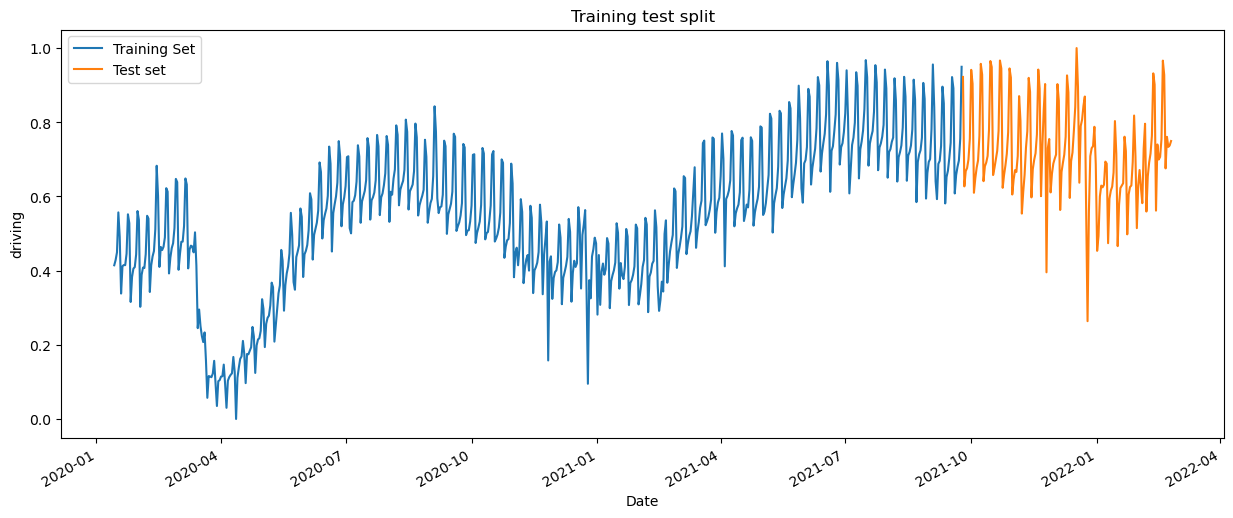

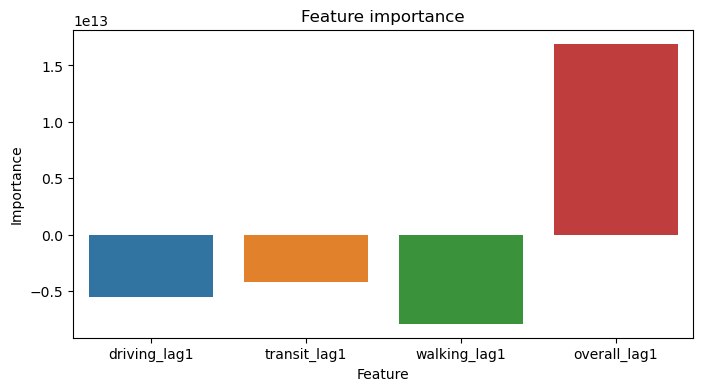

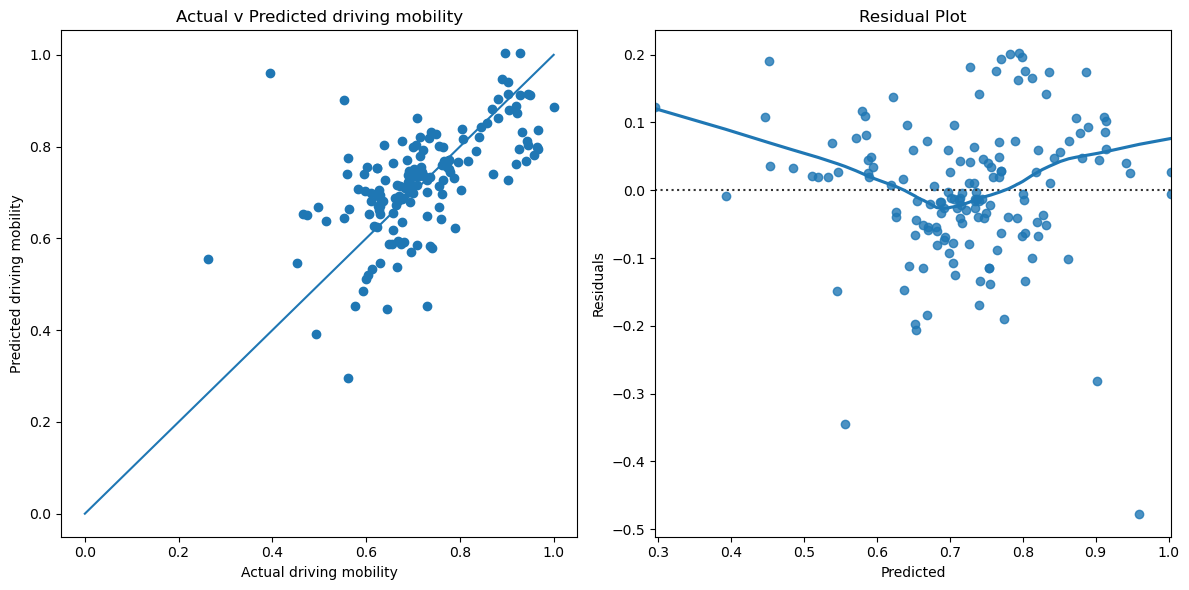

Lag Linear Regression: MSE: 0.0121, RMSE: 0.1101, R-squared: 0.2539


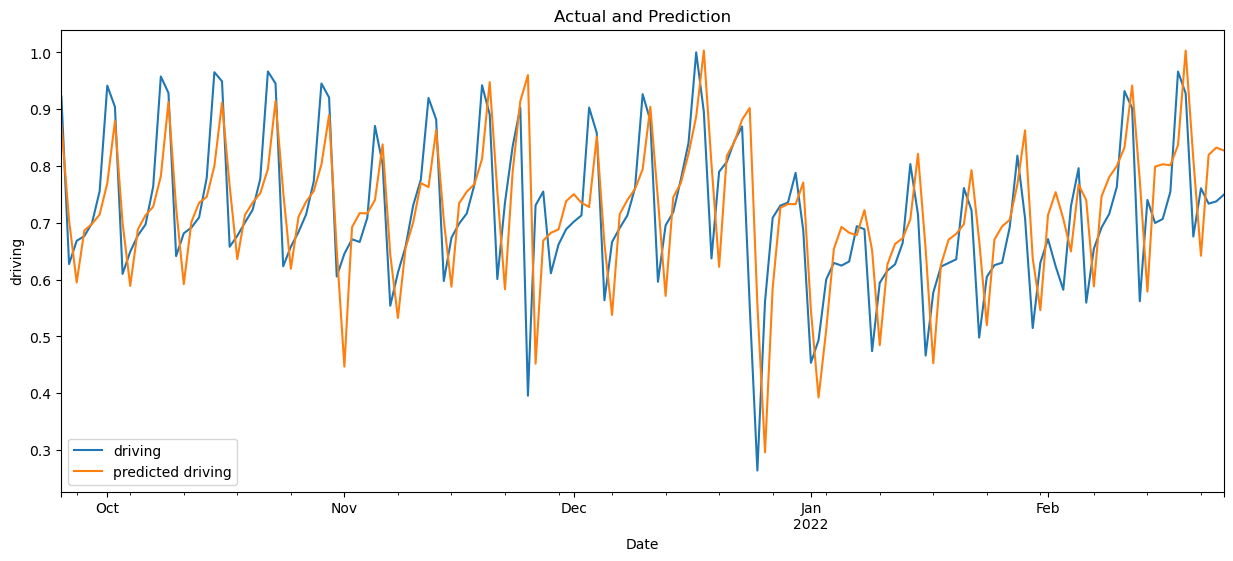

In [7]:
lag1 = weekly_us_processed.copy()
lag1['driving_lag1'] = lag1['driving'].shift(1)
lag1['transit_lag1'] = lag1['transit'].shift(1)
lag1['walking_lag1'] = lag1['walking'].shift(1)
lag1['overall_lag1'] = lag1['overall'].shift(1)
lag1_features = ['driving_lag1', 'transit_lag1', 'walking_lag1', 'overall_lag1']
lag1 = lag1.dropna()
lag1_model, (mse, rmse, r2, _) = pipeline(LinearRegression(), lag1, lag1_features, 'driving')
print(f'Lag Linear Regression: MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

We can use this model to predict next day's driving mobility. Would be useful to compare other columns for prediction and actual values. This would tell us how good lag based linear regression model is. 

N.B. Real life data may be quite different from the training period since most COVID related restrictions are discontinued across United States.
N.B. The feature importance can skewed terribly as the features are highly correlated - overall is a combination of walking, driving, and transit. In addition to that they all get affected by lockdown and seasonal changes. One way to look at it is to sum them all and see the importance of <tt>super-feature</tt>.

In [8]:
for prediction in ['walking', 'transit', 'overall']:
    _model, (mse, rmse, r2, _) = pipeline(LinearRegression(), lag1,  lag1_features, prediction, plot=False)
    print(f'Lag Linear Regression ({prediction}): MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

Lag Linear Regression (walking): MSE: 0.0127, RMSE: 0.1125, R-squared: 0.4039
Lag Linear Regression (transit): MSE: 0.0074, RMSE: 0.0862, R-squared: 0.5557
Lag Linear Regression (overall): MSE: 0.0109, RMSE: 0.1044, R-squared: 0.4003


#### Lag 2 - Linear Regression


In [9]:
lag2 = lag1.copy()
lag2['driving_lag2'] = lag1['driving_lag1'].shift(1)
lag2['transit_lag2'] = lag1['transit_lag1'].shift(1)
lag2['walking_lag2'] = lag1['walking_lag1'].shift(1)
lag2['overall_lag2'] = lag1['overall_lag1'].shift(1)
lag2_features = ['driving_lag2', 'transit_lag2', 'walking_lag2', 'overall_lag2']
lag2 = lag2.dropna()
prediction = "driving"
lag2_model, (mse, rmse, r2, _) = pipeline(LinearRegression(), lag2, lag1_features + lag2_features, prediction, plot=False)
print(f'Lag Linear Regression ({prediction}): MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

Lag Linear Regression (driving): MSE: 0.0115, RMSE: 0.1073, R-squared: 0.2916


Doesn't seem to improve much upon single week lag regression model. So, we can stick with <b><i>lag1_model</i></b>

### Lag 7 - Linear Regression
Weekly lag

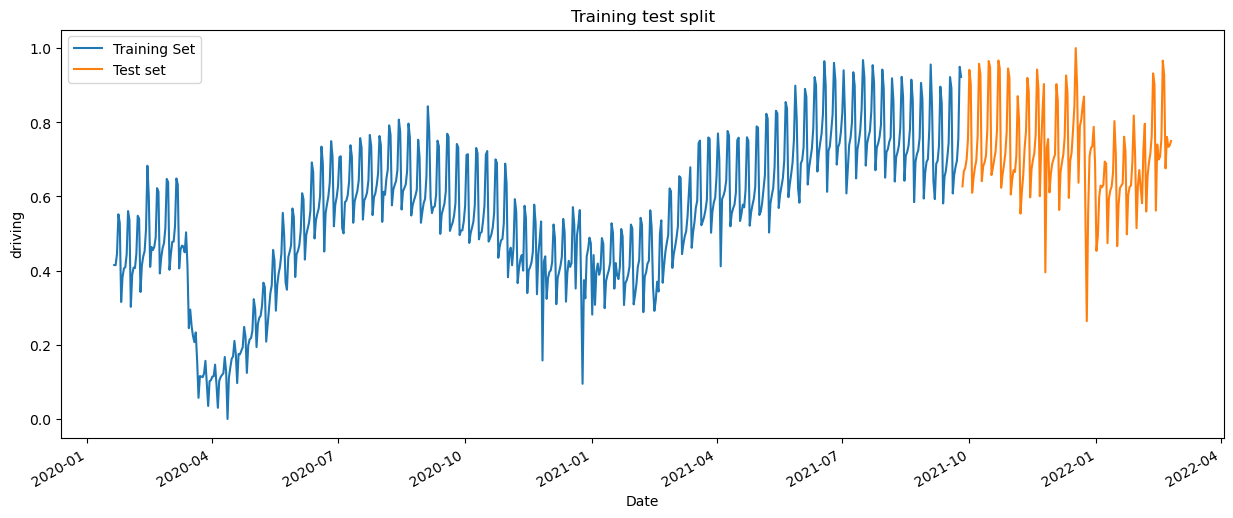

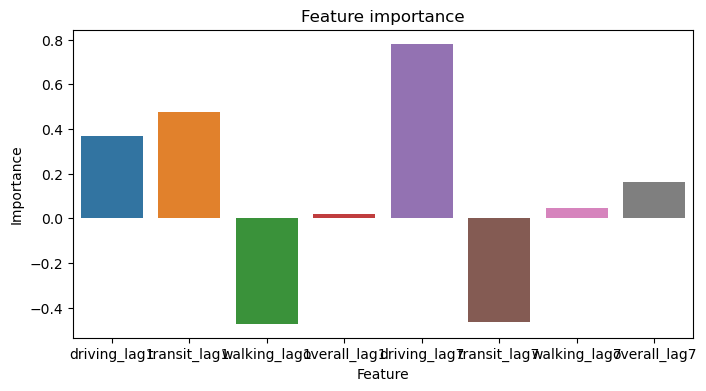

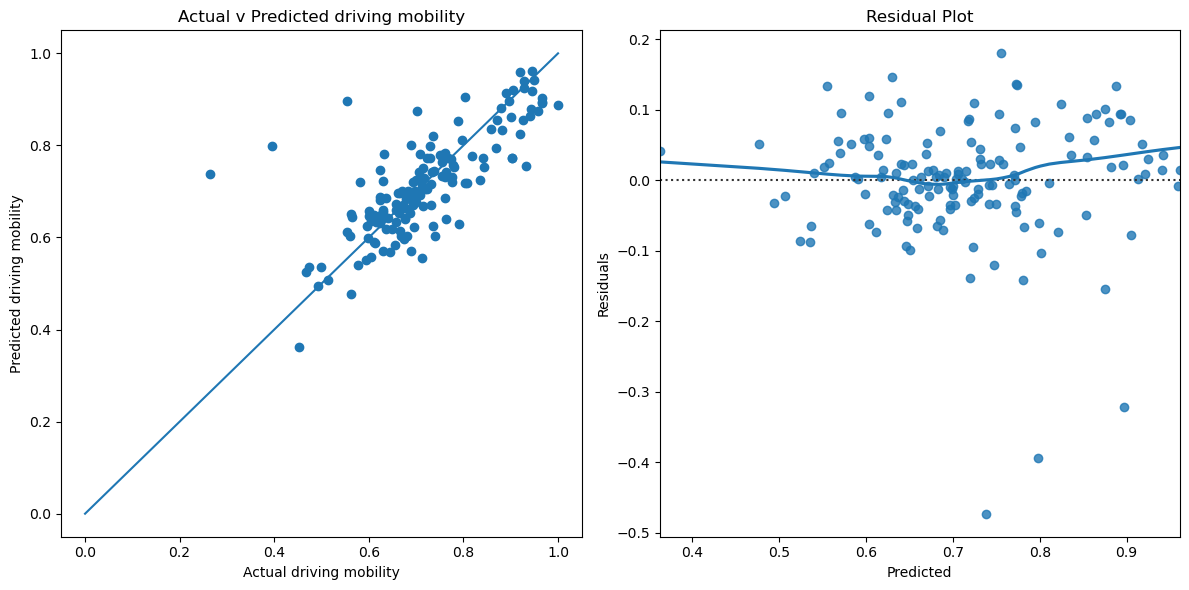

Lag Linear Regression (driving): MSE: 0.0071, RMSE: 0.0846, R-squared: 0.5552


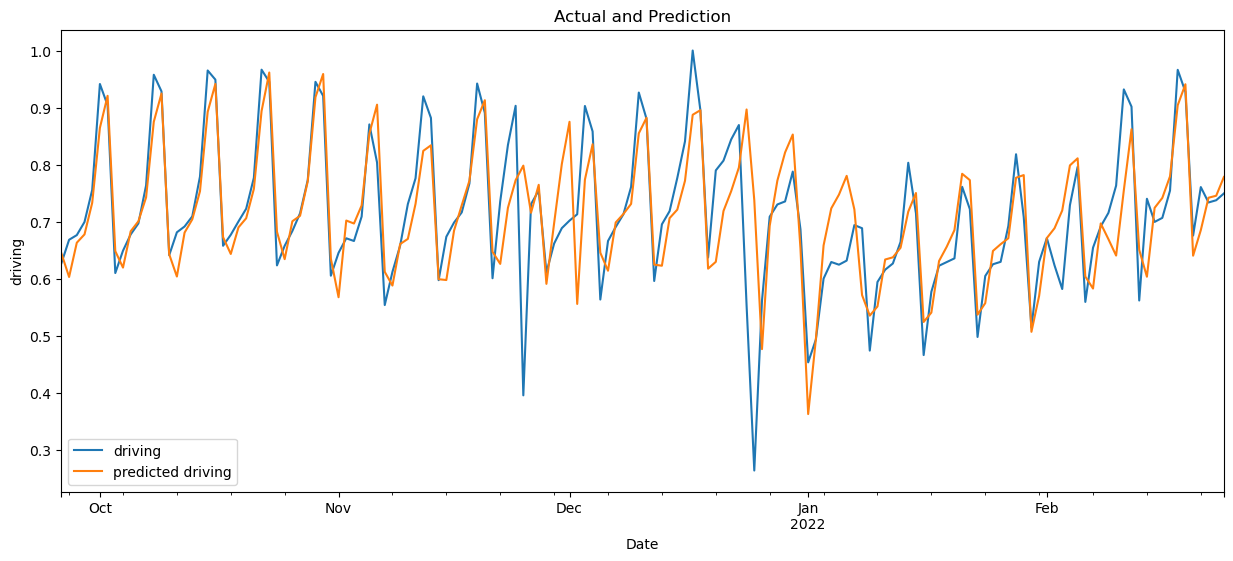

In [10]:
lag7 = lag1.copy()
lag7['driving_lag7'] = lag1['driving'].shift(7)
lag7['transit_lag7'] = lag1['transit'].shift(7)
lag7['walking_lag7'] = lag1['walking'].shift(7)
lag7['overall_lag7'] = lag1['overall'].shift(7)
lag7_features = ['driving_lag7', 'transit_lag7', 'walking_lag7', 'overall_lag7']
lag7 = lag7.dropna()

lag7_model, (mse, rmse, r2, _) = pipeline(LinearRegression(), lag7, lag1_features + lag7_features, prediction)
print(f'Lag Linear Regression ({prediction}): MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

One week lag seems to improve much upon previous lag regression model. So we should pick <b><i>lag7_model</i></b>.

#### Lag 7 - Linear Regression
We can just restrict to lag7 as the feature

In [11]:
lag7_model, (mse, rmse, r2, _) = pipeline(LinearRegression(), lag7, [f"{prediction}_lag7"], prediction, plot=False)
print(f'Lag Linear Regression ({prediction}): MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

Lag Linear Regression (driving): MSE: 0.0099, RMSE: 0.0996, R-squared: 0.3830
